# EDA for Intrusion Detection

In [ ]:
#!pip uninstall pandas_profiling

In [ ]:
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* Importing the needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from collections import Counter

from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             f1_score, ConfusionMatrixDisplay,
                             classification_report, r2_score)
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler 


from scipy.stats import pearsonr
from scipy import stats
from cmath import sqrt
import math
import warnings
warnings.filterwarnings("ignore")
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Importing the dataset


In [ ]:
csv_files = glob.glob('/content/drive/MyDrive/intrusion detection/dataset/*.{}'.format('csv'))
data = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index = True)


In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace = True)
data = data.dropna(axis = "columns", how = "any")

data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849438 entries, 0 to 1849437
Data columns (total 77 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14   Flow IAT Mean                float64
 15   Flow IAT Std                 float64
 16   Flow IAT Max                 int64  
 17   Flow IAT Min                 int64  
 18  Fwd IAT Total         

In [ ]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std',
       ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count',

In [ ]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DDoS', 'PortScan', 'Bot',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

* Removng unicode characters from the *'Label'* column
* Unify sub-classes under the various types of *attacks*

In [ ]:
data[' Label'] = data[' Label'].str.encode('ascii', 'ignore').str.decode('ascii').replace({
    'Web Attack  Brute Force': 'Web Attack', 
    'Web Attack  XSS': 'Web Attack', 
    'Web Attack  Sql Injection': 'Web Attack',
    'FTP-Patator': 'Patator',
    'SSH-Patator': 'Patator',
  })
data[' Label'].value_counts()

BENIGN        1544500
PortScan       158930
DDoS           128027
Patator         13835
Web Attack       2180
Bot              1966
Name:  Label, dtype: int64

# Save dataset for EDA

In [ ]:
y = data[' Label']
X = data.drop([' Label'], axis = 1)

In [ ]:
X.shape, y.shape

((1849438, 76), (1849438,))

# Undersampling Dataset

In [ ]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({'BENIGN': 1544500, 'PortScan': 158930, 'DDoS': 128027, 'Patator': 13835, 'Web Attack': 2180, 'Bot': 1966})


In [ ]:
rand_under_sampling = RandomUnderSampler(random_state=42)
X_res, y_res = rand_under_sampling.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'BENIGN': 1966, 'Bot': 1966, 'DDoS': 1966, 'Patator': 1966, 'PortScan': 1966, 'Web Attack': 1966})


## Select top 10 features for EDA

In [ ]:
select_features = SelectKBest(score_func= f_classif, k = 10)

In [ ]:
X_reduced = select_features.fit_transform(X_res, y_res)

In [ ]:
y_res

0            BENIGN
1            BENIGN
2            BENIGN
3            BENIGN
4            BENIGN
            ...    
11791    Web Attack
11792    Web Attack
11793    Web Attack
11794    Web Attack
11795    Web Attack
Name:  Label, Length: 11796, dtype: object

In [ ]:
filter = select_features.get_support()
features =  np.array(X.columns)
 
print("All features:")
counter = 1
for feature in features:
  print(f'f{counter} = {feature}')
  counter +=1
 

All features:
f1 =  Destination Port
f2 =  Flow Duration
f3 =  Total Fwd Packets
f4 =  Total Backward Packets
f5 = Total Length of Fwd Packets
f6 =  Total Length of Bwd Packets
f7 =  Fwd Packet Length Max
f8 =  Fwd Packet Length Min
f9 =  Fwd Packet Length Mean
f10 =  Fwd Packet Length Std
f11 = Bwd Packet Length Max
f12 =  Bwd Packet Length Min
f13 =  Bwd Packet Length Mean
f14 =  Bwd Packet Length Std
f15 =  Flow IAT Mean
f16 =  Flow IAT Std
f17 =  Flow IAT Max
f18 =  Flow IAT Min
f19 = Fwd IAT Total
f20 =  Fwd IAT Mean
f21 =  Fwd IAT Std
f22 =  Fwd IAT Max
f23 =  Fwd IAT Min
f24 = Bwd IAT Total
f25 =  Bwd IAT Mean
f26 =  Bwd IAT Std
f27 =  Bwd IAT Max
f28 =  Bwd IAT Min
f29 = Fwd PSH Flags
f30 =  Bwd PSH Flags
f31 =  Fwd URG Flags
f32 =  Bwd URG Flags
f33 =  Fwd Header Length
f34 =  Bwd Header Length
f35 = Fwd Packets/s
f36 =  Bwd Packets/s
f37 =  Min Packet Length
f38 =  Max Packet Length
f39 =  Packet Length Mean
f40 =  Packet Length Std
f41 =  Packet Length Variance
f42 = FIN Fla

In [ ]:
print("Selected best 10:")
print(features[filter])

Selected best 10:
['Bwd Packet Length Max' ' Bwd Packet Length Mean'
 ' Bwd Packet Length Std' ' Max Packet Length' ' Packet Length Mean'
 ' Packet Length Std' ' Average Packet Size' ' Avg Bwd Segment Size'
 ' Init_Win_bytes_backward' ' min_seg_size_forward']


* abbr_col_names = 
    ['f11', 'f9', 'f14', 'f38', 'f39', 'f40', 'f51', 'f53', 'f66', 'f68']

In [ ]:
abbr_col_names = ['f11', 'f9', 'f14', 'f38', 'f39', 'f40', 'f51', 'f53', 'f66', 'f68']

In [ ]:
eda_data = pd.DataFrame()
eda_data['f11'] = X_res['Bwd Packet Length Max'].values
eda_data['f9'] = X_res[' Bwd Packet Length Mean'].values
eda_data['f14'] = X_res[' Bwd Packet Length Std'].values
eda_data['f38'] = X_res[' Max Packet Length'].values
eda_data['f39'] = X_res[' Packet Length Mean'].values
eda_data['f40'] = X_res[' Packet Length Std'].values
eda_data['f51'] = X_res[' Average Packet Size'].values
eda_data['f53'] = X_res[' Avg Bwd Segment Size'].values
eda_data['f66'] = X_res[' Init_Win_bytes_backward'].values
eda_data['f68'] = X_res[' min_seg_size_forward'].values

In [ ]:
eda_data.head()

,f11,f9,f14,f38,f39,f40,f51,f53,f66,f68
0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32
1,795,57.214286,212.355355,795,42.709677,160.076897,44.133333,57.214286,946,20
2,119,119.000000,0.000000,119,78.333333,35.218366,117.500000,119.000000,-1,32
3,175,175.000000,0.000000,175,89.666667,73.900834,134.500000,175.000000,-1,40
4,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-1,20


In [ ]:
#eda_data.to_csv('/content/drive/MyDrive/intrusion detection/EDA_data.csv')

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class
#AV = AutoViz_Class()

In [ ]:
eda_file = '/content/drive/MyDrive/intrusion detection/EDA_data.csv'

In [ ]:
eda_data = pd.read_csv(eda_file)

In [ ]:
eda_data.head()

,Unnamed: 0,f11,f9,f14,f38,f39,f40,f51,f53,f66,f68,Label
0,0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,BENIGN
1,1,795,57.214286,212.355355,795,42.709677,160.076897,44.133333,57.214286,946,20,BENIGN
2,2,119,119.000000,0.000000,119,78.333333,35.218366,117.500000,119.000000,-1,32,BENIGN
3,3,175,175.000000,0.000000,175,89.666667,73.900834,134.500000,175.000000,-1,40,BENIGN
4,4,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-1,20,BENIGN


In [ ]:
eda_data.columns

Index(['f11', 'f9', 'f14', 'f38', 'f39', 'f40', 'f51', 'f53', 'f66', 'f68'], dtype='object')

In [ ]:
eda_data.drop(['Unnamed: 0'], axis=1)

,f11,f9,f14,f38,f39,f40,f51,f53,f66,f68,Label
0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,BENIGN
1,795,57.214286,212.355355,795,42.709677,160.076897,44.133333,57.214286,946,20,BENIGN
2,119,119.000000,0.000000,119,78.333333,35.218366,117.500000,119.000000,-1,32,BENIGN
3,175,175.000000,0.000000,175,89.666667,73.900834,134.500000,175.000000,-1,40,BENIGN
4,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-1,20,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...
11791,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,Web Attack
11792,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,Web Attack
11793,370,92.500000,185.000000,383,83.666667,166.052703,94.125000,92.500000,235,32,Web Attack
11794,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,Web Attack


In [ ]:
eda_data.head()

,Unnamed: 0,f11,f9,f14,f38,f39,f40,f51,f53,f66,f68,Label
0,0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,BENIGN
1,1,795,57.214286,212.355355,795,42.709677,160.076897,44.133333,57.214286,946,20,BENIGN
2,2,119,119.000000,0.000000,119,78.333333,35.218366,117.500000,119.000000,-1,32,BENIGN
3,3,175,175.000000,0.000000,175,89.666667,73.900834,134.500000,175.000000,-1,40,BENIGN
4,4,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-1,20,BENIGN


In [ ]:
eda_data = eda_data.drop(['Unnamed: 0'], axis = 1)

In [ ]:
eda_data.head()

,f11,f9,f14,f38,f39,f40,f51,f53,f66,f68,Label
0,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,28960,32,BENIGN
1,795,57.214286,212.355355,795,42.709677,160.076897,44.133333,57.214286,946,20,BENIGN
2,119,119.000000,0.000000,119,78.333333,35.218366,117.500000,119.000000,-1,32,BENIGN
3,175,175.000000,0.000000,175,89.666667,73.900834,134.500000,175.000000,-1,40,BENIGN
4,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-1,20,BENIGN


In [ ]:
profile = ProfileReport(eda_data)

In [ ]:
 profile.to_file(output_file='intrusion_detection_EDA.html')

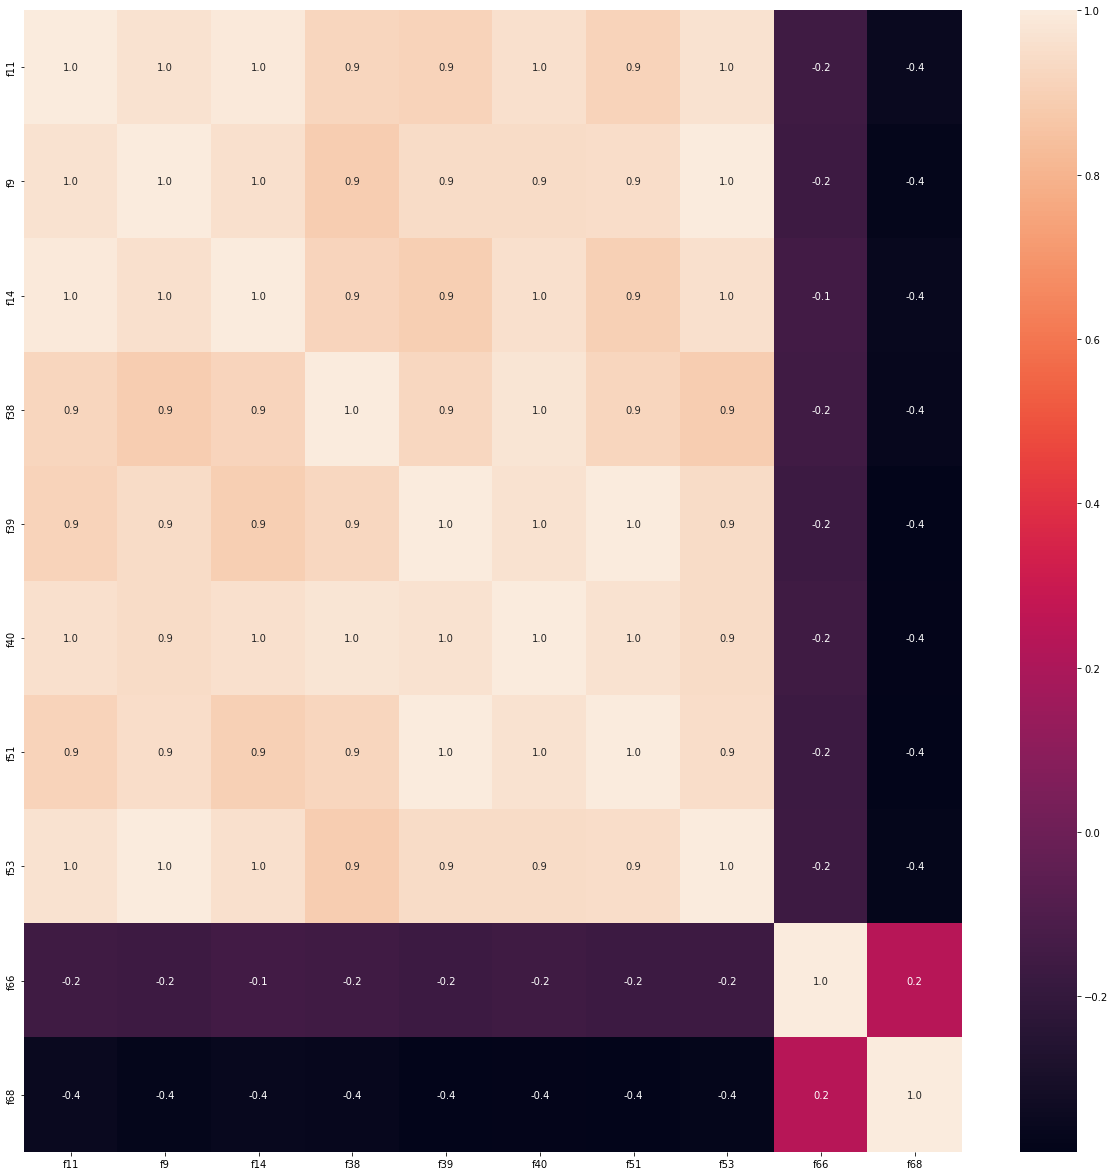

In [ ]:
plt.subplots(figsize = (21,21))
sns.heatmap(eda_data.corr(), annot = True, fmt = '.1f', color = 'green')